# Effect of rescoring on re-ranking PSMs

In [50]:
from denovo_utils.data import Run
from denovo_utils.parsers import DenovoEngineConverter
from denovo_utils.parsers.converters.spectralis import load_spectralis_rescoring
from denovo_utils.io.read import load_psmlist

from psm_utils import PSMList
from tqdm import tqdm
from glob import glob
from itertools import chain

import pandas as pd
import os

# 1. Load the data in Run object

We will only use the following run: LFQ_Orbitrap_DDA_QC_01

The reason for this is simply processing time, as we include the top 10 hits.

In [2]:
from denovo_utils.data.run import read_runs

In [3]:
filenames = ['LFQ_Orbitrap_DDA_QC_01']

root_mgf = f'/public/compomics3/Sam/PXD028735/QExactive/mgf_reformatted'
root_psmlist = f'/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams'
root_postprocessing = f'/public/compomics3/Sam/PXD028735/QExactive/postprocessing_beams'

format_ground_truth = 'parquet'

rescored_db = True
rescored_denovo = True
rescored_refinement = False

In [4]:
runs = read_runs(
    root_denovo_output=root_psmlist,
    root_ground_truth=root_psmlist,
    root_refinement=root_postprocessing,
    root_mgf=root_mgf,
    filenames=filenames,
    engine_names=[
        'casanovo'
    ],
    refinement_names=[
        'spectralis',
        'instanovoplus'
    ],
    format_ground_truth=format_ground_truth,
    rescored_db=rescored_db,
    rescored_denovo=rescored_denovo,
    rescored_refinement=rescored_refinement
)

Loading results from ground_truth.parquet: 100%|██████████| 83941/83941 [00:10<00:00, 7955.94it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_QC_01): 100%|██████████| 83941/83941 [00:04<00:00, 18456.02it/s]
Loading results from casanovo.parquet: 100%|██████████| 352220/352220 [00:48<00:00, 7197.62it/s]
Loading PSMs in Run object (LFQ_Orbitrap_DDA_QC_01): 100%|██████████| 352220/352220 [00:24<00:00, 14123.69it/s]
Parsing Instanovo+ results to PSMList: 100%|██████████| 352183/352183 [00:12<00:00, 28569.72it/s]


In [5]:
run = runs['LFQ_Orbitrap_DDA_QC_01']

In [6]:
gt_spectralis = load_spectralis_rescoring(
    root_path='/public/compomics3/Sam/PXD028735/QExactive/postprocessing_beams/spectralis/parquet',
    filename=filenames[0]
)

parser = DenovoEngineConverter.select('instanovoplus')
gt_instanovoplus = parser.parse(
    result_path='/public/compomics3/Sam/PXD028735/QExactive/postprocessing_beams/instanovoplus/parquet/LFQ_Orbitrap_DDA_QC_01.csv',
    mgf_path=os.path.join(root_mgf, filenames[0]+'.mgf')
)

Parsing Instanovo+ results to PSMList: 100%|██████████| 83938/83938 [00:02<00:00, 29164.41it/s]


In [15]:
# Add re-scored scores to the ground_truth.

for i, row in tqdm(gt_spectralis.iterrows()):
    spectrum = run.get_spectrum(row['title'])
    if spectrum is None:
        continue
    spectrum.psm_gt.scores.add_score(
        score=row['Spectralis_score'],
        metadata='Spectralis',
        score_type='peptide'
    )

scores_added = 0
scores_ignored = 0
for psm in tqdm(gt_instanovoplus):
    spectrum = run.get_spectrum(psm['spectrum_id'])
    if spectrum is None:
        continue

    if spectrum.psm_gt.peptidoform == psm['peptidoform']:
        spectrum.psm_gt.scores.add_score(
            score=psm['score'],
            metadata='InstaNovo+',
            score_type='peptide'
        )
        scores_added += 1
    else:
        scores_ignored += 1

83941it [00:02, 30640.73it/s]
100%|██████████| 83938/83938 [00:00<00:00, 145338.70it/s]


In [25]:
for spectra in run.spectra.values():
    for psm in spectra.psm_candidates:
        try:
            _ = psm.scores.get_score('InstaNovo+')

        except:
            if len(psm.refinement)==0:
                pass
                
            else:
                psm.scores.add_score(
                    psm.refinement['InstaNovo+'][0].scores.get_score('InstaNovo+'),
                    metadata='InstaNovo+',
                    score_type='peptide',
                    overwrite=True
                )

Add the ms2rescore scores fitted with different feature sets

In [53]:
gt_scores_mokapot = pd.read_csv(
    '/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/mokapot_diff_features/gt_scores.csv'
)
casanovo_scores_mokapot = pd.read_csv(
    '/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/mokapot_diff_features/casanovo_candidate_scores.csv'
)

In [58]:
for i, row in tqdm(gt_scores_mokapot.iterrows()):
    spectrum = run.get_spectrum(row['spectrum_id'])
    if spectrum is None:
        continue
    spectrum.psm_gt.scores.add_score(
        score=row['score_default_ms2rescore'],
        metadata='ms2rescore_default',
        score_type='peptide'
    )
    spectrum.psm_gt.scores.add_score(
        score=row['score_ms2rescore_casanovo'],
        metadata='ms2rescore_casanovo',
        score_type='peptide'
    )
    spectrum.psm_gt.scores.add_score(
        score=row['score_ms2rescore_spectralis'],
        metadata='ms2rescore_spectralis',
        score_type='peptide'
    )
    spectrum.psm_gt.scores.add_score(
        score=row['score_ms2rescore_casanovo_spectralis'],
        metadata='ms2rescore_casanovo_spectralis',
        score_type='peptide'
    )

83941it [00:03, 26142.50it/s]


In [59]:
for i, row in tqdm(casanovo_scores_mokapot.iterrows()):
    spectrum = run.get_spectrum(row['spectrum_id'])
    if spectrum is None:
        continue

    for psm in spectrum.psm_candidates:
        if psm.rank == row['rank']:
            psm.scores.add_score(
                score=row['score_default_ms2rescore'],
                metadata='ms2rescore_default',
                score_type='peptide'
            )
            psm.scores.add_score(
                score=row['score_ms2rescore_casanovo'],
                metadata='ms2rescore_casanovo',
                score_type='peptide'
            )
            psm.scores.add_score(
                score=row['score_ms2rescore_spectralis'],
                metadata='ms2rescore_spectralis',
                score_type='peptide'
            )
            psm.scores.add_score(
                score=row['score_ms2rescore_casanovo_spectralis'],
                metadata='ms2rescore_casanovo_spectralis',
                score_type='peptide'
            )

352220it [00:19, 17989.44it/s]


In [60]:
# Get the ranks of correct casanovo predictions and their score
for specid, spectra in run.spectra.items():
    spectra.rerank(
        score_name='casanovo',
        engines='casanovo',
        rank_metadata='casanovo'
    )
    spectra.rerank(
        score_name='score_ms2rescore',
        engines='casanovo',
        rank_metadata='ms2rescore'
    )
    spectra.rerank(
        score_name='Spectralis',
        engines='casanovo',
        rank_metadata='Spectralis'
    )
    spectra.rerank(
        score_name='ms2rescore_default',
        engines='casanovo',
        rank_metadata='ms2rescore_default'
    )
    spectra.rerank(
        score_name='ms2rescore_casanovo',
        engines='casanovo',
        rank_metadata='ms2rescore_casanovo'
    )
    spectra.rerank(
        score_name='ms2rescore_spectralis',
        engines='casanovo',
        rank_metadata='ms2rescore_spectralis'
    )
    spectra.rerank(
        score_name='ms2rescore_casanovo_spectralis',
        engines='casanovo',
        rank_metadata='ms2rescore_casanovo_spectralis'
    )

    # If InstaNovo+ changed the peptide sequence,
    # just rank as it would.
    # Create the table for rank and correctness separately
    # spectra.rerank(
    #     score_name='InstaNovo+',
    #     engines='casanovo',
    #     rank_metadata='InstaNovo+'
    # )

In [61]:
for specid, spectra in tqdm(run.spectra.items()):
    
    spectra.compare_gt(
        metadata_score='InstaNovo+',
        refinements=['InstaNovo+'],
        ignore_score=True
    )
    spectra.compare_gt(
        metadata_score='score_ms2rescore',
        ignore_score=True
    )

100%|██████████| 61132/61132 [01:54<00:00, 536.16it/s] 


Get correct spectra for InstaNovo+ if they are there

In [62]:
run_correct = run.get_correct_spectra(
    engines='casanovo',
    score_metadata='score_ms2rescore'
)

In [63]:
run_correct

35222 spectra loaded from 1 engines (['casanovo']).

In [67]:
reranking_data = []

for specid, spectra in tqdm(run_correct.spectra.items()):
    psm = spectra.psm_candidates[0]

    datapoint = {}

    datapoint['spectrum_id'] = specid
    datapoint['Casanovo'] = psm.metadata['casanovo']
    # datapoint['MS2Rescore'] = psm.metadata['ms2rescore']
    # datapoint['InstaNovo+'] = psm.metadata['InstaNovo+']
    datapoint['Spectralis'] = psm.metadata['Spectralis']
    datapoint['ms2rescore_default'] = psm.metadata['ms2rescore_default']
    datapoint['ms2rescore_casanovo'] = psm.metadata['ms2rescore_casanovo']
    datapoint['ms2rescore_spectralis'] = psm.metadata['ms2rescore_spectralis']
    datapoint['ms2rescore_casanovo_spectralis'] = psm.metadata['ms2rescore_casanovo_spectralis']
    
    # datapoint['IN+ validity'] = psm.refinement['InstaNovo+'][1]

    reranking_data.append(datapoint)

100%|██████████| 35222/35222 [00:00<00:00, 441426.53it/s]


In [69]:
reranking_df = pd.DataFrame(reranking_data)
reranking_df_melted = reranking_df.melt(
    id_vars=['spectrum_id'],
    value_vars=[
        'Casanovo',
        # 'MS2Rescore',
        'Spectralis',
        'ms2rescore_default',
        'ms2rescore_casanovo',
        'ms2rescore_spectralis',
        'ms2rescore_casanovo_spectralis'
    ]
)
reranking_df_melted = reranking_df_melted.value_counts(['variable', 'value']).reset_index()
reranking_df_counts = reranking_df_melted.rename(columns={
    'variable': 'Scoring method',
    'value': 'PSM rank',
    0: '# correct PSMs'
})

<Axes: xlabel='PSM rank', ylabel='# correct PSMs'>

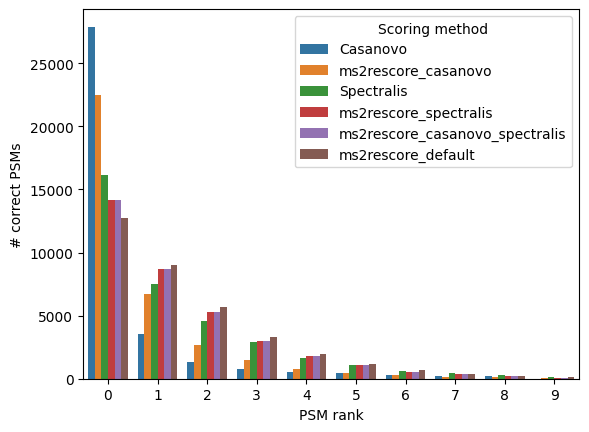

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.barplot(
    reranking_df_counts,
    x='PSM rank',
    y='# correct PSMs',
    hue='Scoring method'
)

<Axes: xlabel='PSM rank', ylabel='# correct PSMs'>

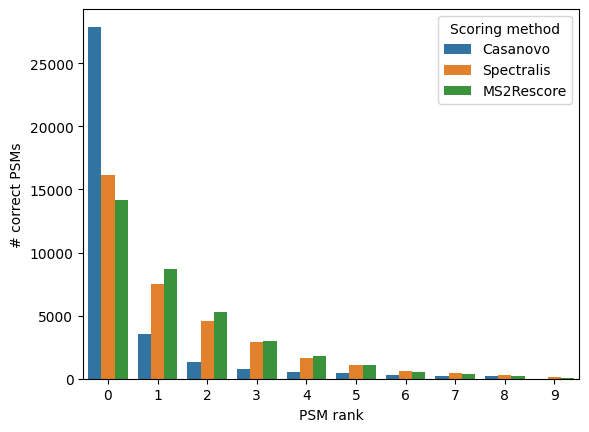

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.barplot(
    reranking_df_counts,
    x='PSM rank',
    y='# correct PSMs',
    hue='Scoring method'
)

In [42]:
correct_spectra = list(run_correct.spectra.keys())

In [43]:
run_false = Run(run_id='False identifications')
for spectrum in run.spectra.keys():

    if spectrum in correct_spectra:
        continue
    run_false.add_spectrum(
        run.get_spectrum(spectrum)
    )

In [ ]:
# reranking_df = pd.DataFrame(reranking_data)
# reranking_df_melted = reranking_df.melt(
#     id_vars=['spectrum_id', 'IN+ validity'],
#     value_vars=['Casanovo', 'MS2Rescore', 'Spectralis', 'InstaNovo+']
# )
# reranking_df_melted = reranking_df_melted[
#     reranking_df_melted['IN+ validity']
# ].value_counts(['variable', 'value']).reset_index()
# reranking_df_counts = reranking_df_melted.rename(columns={
#     'variable': 'Scoring method',
#     'value': 'PSM rank',
#     0: '# correct PSMs'
# })

NameError: name 'reranking_data' is not defined

<Axes: xlabel='PSM rank', ylabel='# correct PSMs'>

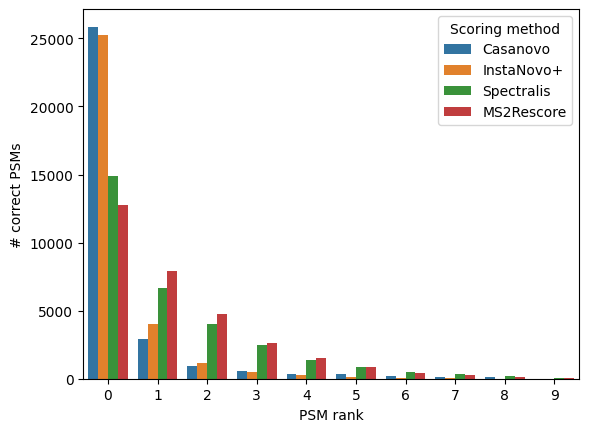

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.barplot(
    reranking_df_counts,
    x='PSM rank',
    y='# correct PSMs',
    hue='Scoring method'
)

In [83]:
reranking_df[reranking_df['MS2Rescore']==9]

,spectrum_id,Casanovo,MS2Rescore,InstaNovo+,Spectralis,IN+ validity
756,controllerType=0 controllerNumber=1 scan=108081,0,9,0,4,True
1934,controllerType=0 controllerNumber=1 scan=70415,0,9,0,0,True
2489,controllerType=0 controllerNumber=1 scan=108111,7,9,7,0,False
3280,controllerType=0 controllerNumber=1 scan=80930,3,9,3,9,False
3285,controllerType=0 controllerNumber=1 scan=74363,1,9,1,2,True
...,...,...,...,...,...,...
33208,controllerType=0 controllerNumber=1 scan=31968,8,9,9,9,False
33717,controllerType=0 controllerNumber=1 scan=37054,4,9,4,9,False
34308,controllerType=0 controllerNumber=1 scan=66847,7,9,7,8,False
34553,controllerType=0 controllerNumber=1 scan=113164,5,9,5,9,False


In [28]:
from pyteomics.mass import calculate_mass

calculate_mass('LLGK')

429.29511937253

In [78]:
calculate_mass('TV') - calculate_mass('SL')

0.0

In [ ]:
LNS<SD>P<SL>LLGK/2
LNS<SD>P<SL>I<GL>K/2

In [ ]:
ms2rescore_2 = LNS<SD>P<SL>LAVK/2
ms2rescore_1 = LNS<SD>P<TV>L<GL>K/2
ground_truth = LNS<SD>P<SL>L<GL>K/2

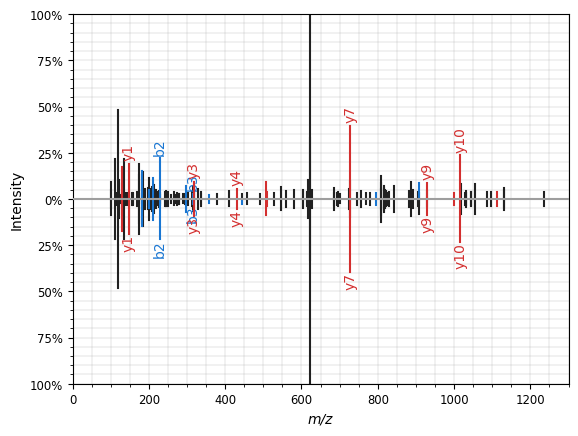

In [84]:
peptide = ''
spec = plot_spectrum(
    peak_path='/public/compomics3/Sam/PXD028735/QExactive/mgf_reformatted/LFQ_Orbitrap_DDA_QC_01.mgf',
    spectrum_id='controllerType=0 controllerNumber=1 scan=71841',
    peptide='LNSSDPTVLAVK/2',
    peak_format='mgf',
    plot=False
)
spec_1 = spec.annotate_proforma(
    proforma_str='LNSSDPTVLAVK/2',
    fragment_tol_mass=20,
    fragment_tol_mode='ppm',
    ion_types='by',
    max_ion_charge=2,
    neutral_losses=True
)

spec = plot_spectrum(
    peak_path='/public/compomics3/Sam/PXD028735/QExactive/mgf_reformatted/LFQ_Orbitrap_DDA_QC_01.mgf',
    spectrum_id='controllerType=0 controllerNumber=1 scan=71841',
    peptide='LNSSDPSLLGLK/2',
    peak_format='mgf',
    plot=False
)
spec_2 = spec.annotate_proforma(
    proforma_str='LNSSDPSLLGLK/2',
    fragment_tol_mass=20,
    fragment_tol_mode='ppm',
    ion_types='by',
    max_ion_charge=2,
    neutral_losses=True
)

sup.mirror(spec_1, spec_2)
plt.show()

In [22]:
run.get_spectrum('controllerType=0 controllerNumber=1 scan=71841')

Spectrum ID: controllerType=0 controllerNumber=1 scan=71841
Ground-truth: LNS<SD>P<SL>I<GL>K/2 ({'peptide': {'sage': 0.8949041366577148}, 'aa': {}})
Candidates:
	LNS<SD>P<SL>L<GL>K/2 ({'peptide': {'casanovo': 0.9832282066345215, 'score_ms2rescore': 0.44608533944973616, 'InstaNovo+': -0.0041750222444534, 'Spectralis': -1.5360224894626695}, 'aa': {'casanovo': (0.98606, 0.98055, 0.98663, 0.98656, 0.97671, 0.98712, 0.98781, 0.96158, 0.98631, 0.9867, 0.98225, 0.98668)}})
	LNS<SN[UNIMOD:7]>P<SL>L<GL>K/2 ({'peptide': {'casanovo': 0.9136099219322205, 'score_ms2rescore': 0.45205894197322377, 'Spectralis': -1.5360224894626693}, 'aa': {'casanovo': (0.95126, 0.94574, 0.95182, 0.95175, 0.94191, 0.95231, 0.953, 0.46676, 0.95185, 0.95231, 0.95334, 0.95256)}})
	LNS<SD>P<TV>L<GL>K/2 ({'peptide': {'casanovo': 0.9114686846733093, 'score_ms2rescore': 2.2050692472339963, 'InstaNovo+': -0.2735790610313415, 'Spectralis': -1.361631441848829}, 'aa': {'casanovo': (0.95018, 0.94467, 0.95075, 0.95068, 0.46632, 0.

In [17]:
from denovo_utils.io.read import read_features, load_pickle
features = read_features('/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/features/casanovo.parquet')
feature_names = load_pickle(
    '/public/compomics3/Sam/PXD028735/QExactive/rescoring_beams/LFQ_Orbitrap_DDA_QC_01/mokapot/feature_names.pkl'
)
feature_names = [feature_name.split(':')[1] for feature_name in feature_names]

In [15]:
def get_features_specid(df, specid, feature_names):

    def parse_to_df(row, feature_names):
        df = pd.DataFrame({k:[v] for k,v in row['rescoring_features'].items()})[feature_names].T
        df = df.rename(columns={0: row['rank']})
        return df

    features_spectrum = df[df['spectrum_id']==specid]
    feature_df = features_spectrum.apply(
        lambda x: parse_to_df(x, feature_names),
        axis=1
    )
    feature_df = pd.concat(feature_df.tolist(), axis=1).T.reset_index()
    feature_df = feature_df.rename(columns={'index': 'rank'})
    return pd.merge(features_spectrum, feature_df, on='rank')


spectrum_id = 'controllerType=0 controllerNumber=1 scan=70415'

In [18]:
spectrum_id = 'controllerType=0 controllerNumber=1 scan=108111'
get_features_specid(
    df=features,
    specid=spectrum_id,
    feature_names=feature_names
)

,spectrum_id,rank,run,source,rescoring_features,hyperscore,missing_frag_sites,missing_frag_pct,ppm_precursor,ppm_mean_y,ppm_mean_b,explained_y_pct,explained_b_pct,explained_all_pct,charge_n,spec_mse_norm,cos,observed_retention_time,rt_diff
0,controllerType=0 controllerNumber=1 scan=108111,1,LFQ_Orbitrap_DDA_QC_01.casanovo.mztab,Casanovo4.2.0,"{'abs_diff_Q1': 7.156922947615385e-07, 'abs_di...",47.124755,6.0,25.000000,2.638649,0.575558,3.457264,0.203092,0.010215,0.324367,3.0,0.440065,0.912320,112.148521,11.285517
1,controllerType=0 controllerNumber=1 scan=108111,2,LFQ_Orbitrap_DDA_QC_01.casanovo.mztab,Casanovo4.2.0,"{'abs_diff_Q1': 4.19249408878386e-06, 'abs_dif...",47.124755,7.0,29.166667,1.402044,3.403283,3.457264,0.203092,0.010215,0.318355,3.0,2.549360,0.359264,112.148521,8.803870
2,controllerType=0 controllerNumber=1 scan=108111,3,LFQ_Orbitrap_DDA_QC_01.casanovo.mztab,Casanovo4.2.0,"{'abs_diff_Q1': 1.9777799025177956e-06, 'abs_d...",47.124755,7.0,29.166667,1.402044,3.403283,3.457264,0.203092,0.010215,0.318355,3.0,2.468617,0.364859,112.148521,10.556121
3,controllerType=0 controllerNumber=1 scan=108111,4,LFQ_Orbitrap_DDA_QC_01.casanovo.mztab,Casanovo4.2.0,"{'abs_diff_Q1': 2.2033345885574818e-06, 'abs_d...",47.124755,7.0,28.000000,1.402146,3.403283,3.457264,0.203092,0.010215,0.325969,3.0,0.468146,0.899273,112.148521,15.618727
4,controllerType=0 controllerNumber=1 scan=108111,5,LFQ_Orbitrap_DDA_QC_01.casanovo.mztab,Casanovo4.2.0,"{'abs_diff_Q1': 0.0, 'abs_diff_Q1_norm': 0.0, ...",47.124755,6.0,25.000000,1.402007,3.403283,3.457264,0.203092,0.010215,0.338682,3.0,0.495607,0.891733,112.148521,14.838961
5,controllerType=0 controllerNumber=1 scan=108111,6,LFQ_Orbitrap_DDA_QC_01.casanovo.mztab,Casanovo4.2.0,"{'abs_diff_Q1': 1.9777799025177956e-06, 'abs_d...",47.124755,6.0,25.000000,1.402044,3.403283,3.457264,0.203092,0.010215,0.338682,3.0,2.531066,0.352866,112.148521,8.789460
6,controllerType=0 controllerNumber=1 scan=108111,7,LFQ_Orbitrap_DDA_QC_01.casanovo.mztab,Casanovo4.2.0,"{'abs_diff_Q1': 0.0, 'abs_diff_Q1_norm': 0.0, ...",47.124755,6.0,25.000000,1.402007,3.403283,3.457264,0.203092,0.010215,0.322186,3.0,0.544609,0.906666,112.148521,8.692059
7,controllerType=0 controllerNumber=1 scan=108111,8,LFQ_Orbitrap_DDA_QC_01.casanovo.mztab,Casanovo4.2.0,"{'abs_diff_Q1': 0.0, 'abs_diff_Q1_norm': 0.0, ...",47.124755,6.0,25.000000,1.402044,3.403283,3.457264,0.203092,0.010215,0.338682,3.0,2.495095,0.364366,112.148521,13.875696
8,controllerType=0 controllerNumber=1 scan=108111,9,LFQ_Orbitrap_DDA_QC_01.casanovo.mztab,Casanovo4.2.0,"{'abs_diff_Q1': 0.0, 'abs_diff_Q1_norm': 0.0, ...",47.124755,7.0,29.166667,1.402007,3.403283,3.457264,0.203092,0.010215,0.318355,3.0,0.502098,0.894634,112.148521,15.168656
9,controllerType=0 controllerNumber=1 scan=108111,10,LFQ_Orbitrap_DDA_QC_01.casanovo.mztab,Casanovo4.2.0,"{'abs_diff_Q1': 4.29665669798851e-06, 'abs_dif...",47.124755,6.0,24.000000,1.402146,3.403283,3.457264,0.203092,0.010215,0.329801,3.0,0.463972,0.896388,112.148521,17.479179
